# Exercise 4


Comparison of a convolutional neural network and a XGBoost on the same problem with classification of timeseries. The convolution network has been given the original generated data, while the XGBoost has been trained with the extracted features using tsfresh.

## Imports

In [1]:
# General
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Visualization
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython import display

# NN
import tensorflow as tf
import tensorflow.random as tf_r
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

# XGB
from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree

# Progress bar
from tqdm import tqdm

# Correct path between operating systems
import os 


C:\Users\chris\anaconda3\envs\nn\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Creating models

The CNN-model used in the task is the same as used in exercise 3 from last week. A convolution network with Lasso-regularization.

In [2]:
L = 60
input_shape = (L, 1)
n_class = 3
BATCH_SIZE = 250
EPOCHS = 100


def create_CNNmodel(*,NCONV = 1,NF = 5,reg_type = 1,reg_lambda = 0.5,set_seed = True):
    """creates a compiled CNNmodel

    Parameters
    ----------
    NCONV : int, optional
        Number of CONV layers 1 or 2, by default 1
    NF : int, optional
        number of filters in CONV layers, by default 5
    reg_type : int, optional
        L1 or L2 regression 1,2 , by default 1
    reg_lambda : float, optional
        lambda used in regression, by default 0.5
    set_seed : bool, optional
        Sets seed to 12345 if True else not, by default True

    Returns
    -------
    keras.Sequential
        compiled CNN model
    """
    if set_seed:
        # reproducibility
        np.random.seed(12345)
        tf_r.set_seed(12345)

    ## from keras import regularizers, initializers
    if reg_type == 2:
        reg = tf.keras.regularizers.l2(reg_lambda) ## raised to 0.2

    elif reg_type == 1:
        reg = tf.keras.regularizers.l1(reg_lambda)

    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, 
                                            seed=None)
    
    model = Sequential()     
    if NCONV==1:
        
        model.add(Conv1D(filters=NF, kernel_size=11, 
                        kernel_initializer=ini, 
                        kernel_regularizer=reg,
                        activation='relu', input_shape=input_shape))
        model.add(AveragePooling1D(5))
        model.add(Flatten())
        model.add(Dense(9, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(6, activation='relu'))
        model.add(Dropout(0.2))
    
    if NCONV==2:
        model.add(Conv1D(filters=NF, kernel_size=11, 
                        kernel_initializer=ini, 
                        kernel_regularizer=reg,
                        activation='relu', 
                        input_shape=input_shape))
        model.add(AveragePooling1D(5))
        model.add(Conv1D(filters=5, kernel_size=7, 
                        activation='relu'))
        model.add(Flatten())
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))

    model.add(Dense(n_class, activation='softmax'))
    opt = tf.keras.optimizers.Adam()

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=opt,metrics=['accuracy'])
    
    return model

def create_XGTBoostmodel(*,
    set_seed = True,
    eval_metric = "mlogloss",
    use_label_encoder = False,
    max_depth = 6,
    min_child_weight = 1,
    learning_rate = 0.3,
    **kwargs
    ):
    """creates a XGB model ready for trainign

    Parameters
    ----------
    set_seed : bool, optional
        sets seed to 12345 if True else not, by default True
    eval_metric : str, optional
        evaluation metric used by XGB, by default "mlogloss"
    use_label_encoder : bool, optional
        not realy sure, so keep False ;), by default False
    max_depth : int, optional
        largest depth of trees, by default 6
    min_child_weight : float, optional
        sum of weights after a partition larger is more conservative, by default 1
    learning_rate : float, optional
        the learning rate duh, by default 0.3

    Returns
    -------
    XGBClassifier
        the XGB model ready for use
    """
    
    if set_seed:
        np.random.seed(12345)

    #build model with given params
    model = XGBClassifier(
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        learning_rate = learning_rate,
        use_label_encoder = use_label_encoder,
        eval_metric = eval_metric,
        **kwargs)
    return model

## Loading and Preparing data

In [3]:
# for task 1
def load_data(filename):
    """
    Loades the data from the file with the filename if DATA folder (with "x_","y_" before).
    Returns x and y (one hot)
    """
    str0 = filename
    fnamex='DATA/x_'+str0
    fnamey='DATA/y_'+str0
    

    x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
    N,L = len(x), len(x[0])


    categ = np.loadtxt(fnamey, dtype=int)
    n_class = 3    # y.argmax() - y.argmin() +1
    # print('data: ',N)

    y = np.zeros((N,n_class))
    for i in range(N):
        y[i][categ[i]] = 1.

    return x,y

def get_df(x):
    '''
    Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    # build id columns
    id_col = np.repeat(np.arange(N),t)
    # build time columns
    time_col = np.tile(np.arange(t),N)
    # build var columns
    x_col = x.flatten()
      
    # build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

def time_series_split(x_in,y_in,*,N_train = 1000, N_valid = 1000):
    """splits x and y into training and validations sets

    Parameters
    ----------
    x_in : ndarray
        time series data
    y_in : ndarray
        the labels
    N_train : int, optional
        number of training samples, by default 1000
    N_valid : int, optional
        number of validation samples, by default 1000

    Returns
    -------
    tuple(ndaray)
        x_train , y_tain, x_valid, y_valid
    """
    permutation = np.random.permutation(N_train+N_valid)
    x = np.copy(x_in)
    y = np.copy(y_in)
    
    N = len(x)
    # rescaling stuff
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]
    
    x = x/400
    
    x_train , y_train = np.copy(x[permutation[:N_train]]), np.copy(y[permutation[:N_train]])
    x_valid , y_valid = np.copy(x[permutation[N_train:]]), np.copy(y[permutation[N_train:]])

    x_train.shape = (x_train.shape[0],x_train.shape[1],1)
    x_valid.shape = (x_valid.shape[0],x_valid.shape[1],1)

    return x_train, y_train, x_valid, y_valid


def features_split(x,y,*,N_train = 1000, N_valid = 1000):
    """
    inputs
    ----------
    x : x_features.values, not the df
    y : the normal y values with one hot

    returns
    ----------
    x_train,y_train, x_valid, y_valid

    where y_s have been converted to single int
    
    """
    permutation = np.random.permutation(N_train+N_valid)
    x_train , y_train = x[permutation[:N_train]], np.argmax(y[permutation[:N_train]], axis = 1) 

    x_valid , y_valid = x[permutation[N_train:]], np.argmax(y[permutation[N_train:]],axis = 1)

    return x_train, y_train, x_valid, y_valid

In [ ]:
# for task 2 copied from assignment

L = 2
N_TRAIN = 4000
N_VALID = 4000

def rescale(x,x_ref,RTYPE = 2):
    """
    Returns a copy of the x-data rescale acording to TYPE with x_ref as
    the reference date to scale wrt.

    Inputs
    ----------
    x : data array of d
    x : data array that the rescaling is done wrt.
    RTYPE : determines what type of rescaling is used
        - 0 - do nothing
        - 1 - normalize based on max and min of x_ref
        - 2 - standarize based on avg and std of x_ref (default)
    """
    # Create output
    x_out = np.zeros(x.shape)
    
    # Check what type to use
    if RTYPE == 0:
        x_out = np.copy(x)
        return x_out
    
    if RTYPE == 1:
        # normalization, for each dimension
        for i in range(L):
            x_out[:,i] = (x[:,i]-np.max(x_ref[:,i]))/(-np.max(x_ref[:,i])+np.min(x_ref[:,i]))*2-1
        return x_out
    
    if RTYPE == 2:
        # standardization, for each dimension
        for i in range(L):
            x_out[:,i] = (x[:,i]-np.mean(x_ref[:,i]))/(np.std(x_ref[:,i]))
        return x_out


def non_linear_func(x ,TYPE = 0):
    """
    returns labels of x, uses the non-linear function determined
    by TYPE
    
    inputs
    ----------
    x : data array
    TYPE : determines func used
        - 0 : triangle
        - 1 : circle
        - 2 : sine
        - 3 : sine, but flip for x_0 > 0
        - 4 : Smiley face
    """
    # Create output array
    r= np.zeros(x.shape[0])
    
    # Check what type
    if TYPE == 0:
        # Triangle
        for i,x_i in enumerate(x):
            r[i] = x_i[0]>-20 and x_i[1]>-40 and x_i[0]+x_i[1] < 40
        
    if TYPE == 1:
        # Circle
        for i,x_i in enumerate(x):
            r[i] = x_i[0]*x_i[0] + x_i[1]*x_i[1] < 30*30
    
    if TYPE == 2:
        # Sine
        for i,x_i in enumerate(x):
            r[i] = x_i[1] > np.sin(2*np.pi/100 *(x_i[0]-50))*25
            
    if TYPE == 3:
        # Sine, flips halfway
        for i,x_i in enumerate(x):
            if x_i[0] < 0:
                r[i] = x_i[1] > np.sin(2*np.pi/100 *(x_i[0]-50))*25
            else:
                r[i] = x_i[1] < np.sin(2*np.pi/100 *(x_i[0]-50))*25
    
    if TYPE == 4:
        # Smiley face
        for i,x_i in enumerate(x):
            if (x_i[0]+25)**2 + (x_i[1]-25)**2 < 15**2:
                r[i]=1
            elif (x_i[0]-25)**2 + (x_i[1]-25)**2 < 15**2:
                r[i] = 1
            elif (x_i[0])**2 + (x_i[1]-15)**2 < 8**2:
                r[i] = 1
            
            if (x_i[0])**2 + (x_i[1]+10)**2 < 35**2 and x_i[1] < -10:
                r[i] = 1
            if (x_i[0])**2 + (x_i[1]+18)**2 < 20**2 and x_i[1] < -18:
                r[i] = 0 
    return r

def create_datapoints(N=4000,L=L,B=100,TYPE = 0):
    """
    Creates datapoints and returns x,y, where y is the labels
    given by the non-linear function of TYPE

    Inputs
    ----------
    N : number of datapoints, default 4000
    L : size of each sample, default 2
    B : box size, default 100
    TYPE : type of labeling, passed to non_linear_func

    Outputs
    ---------
    x : np.array of shape (N,L) with data, NOT RESCALED
    y : np.array of shape (N,) with labels from non_linear_func
    """
    x = (np.random.random((N,L))-0.5)*B
    y = non_linear_func(x,TYPE = TYPE)
    return x,y

def create_datasets(N_train=N_TRAIN,N_valid = N_VALID,L=L,B=100,TYPE = 0,RTYPE = 2):
    """
    Creates datapoints and returns data sets for training and validation already rescaled

    Inputs
    ----------
    N_test : number of test datapoints, default 3200
    N_valid : number of validation datapoints, default 800
    L : size of each sample, default 2
    B : box size, default 100
    TYPE : type of labeling, passed to non_linear_func
    RTYPE : type of rescaling, passed to rescale

    Outputs
    ---------
    x_train,y_train,x_valid,y_valid

    """
    x,y = create_datapoints(N= N_valid+N_train,L=L,B=B,TYPE=TYPE)

    x_train, y_train =rescale(x[:N_train],x[:N_train],RTYPE=RTYPE) ,y[:N_train]
    x_valid, y_valid =rescale(x[N_train:],x[:N_train],RTYPE=RTYPE), y[N_train:]
    
    return x_train,y_train,x_valid,y_valid

## Generating Features from time series

In [4]:
str0 = f'ts_L60_Z12_A1000_DX50_bias5_N10000.dat'
x, y = load_data(str0)

FEATURE_FILEPATH = os.path.join("DATA","x_features1000.csv")

In [6]:
df = get_df(x)

# extract features
x_features = extract_features(
                            df, #our dataframe
                            column_id='id', #sample id, from 0 to N
                            column_sort='time', #timestep, from 0 to t
                            column_kind=None, #we have only one feature
                            column_value='value', #value of input 
                            n_jobs=4) #number of cores

# remove columns with NaN or inf
x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')


# Save features so one does not need to recompute them
x_features.to_csv(FEATURE_FILEPATH,index=False)

Feature Extraction: 100%|██████████| 20/20 [03:52<00:00, 11.63s/it]


In [7]:
# Read file so not need to recompute after kernel restart
x_features = pd.read_csv(FEATURE_FILEPATH)

## Task 1.a Number of Training Samples

In [8]:
N_check = 10
# Added some more samples than whats in the task to see when they where compariable
Ns = [20, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 2000, 5000] 
N_validation = 5000 # Since we have a lot of samples

accuracy_scores_CNN = np.zeros((N_check,len(Ns)))
accuracy_scores_XGB = np.zeros((N_check,len(Ns)))

for n in tqdm(range(N_check)):
    for i,N in enumerate(Ns):
        CNN_model = create_CNNmodel(set_seed = False)
        x_train,y_train,x_valid,y_valid = time_series_split(x,y,N_train=N, N_valid = N_validation )
        CNN_model.fit(x_train,y_train,verbose=0,epochs=EPOCHS,batch_size= BATCH_SIZE)

        y_pred_valid = CNN_model.predict(x_valid)
    
        accuracy_scores_CNN[n,i] = accuracy_score(np.argmax(y_valid,axis = 1),np.argmax(y_pred_valid,axis = 1))

        XGB_model = create_XGTBoostmodel(set_seed = False)
        x_train,y_train,x_valid,y_valid = features_split(x_features.values,y,N_train=N)
        XGB_model.fit(x_train,y_train,verbose=0)

        y_pred_val = XGB_model.predict(x_valid)
        accuracy_scores_XGB[n,i] = accuracy_score(y_valid,y_pred_val)

  0%|                                                                                            | 0/10 [00:00<?, ?it/s]2022-03-30 22:40:51.608510: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [34:38<00:00, 207.85s/it]


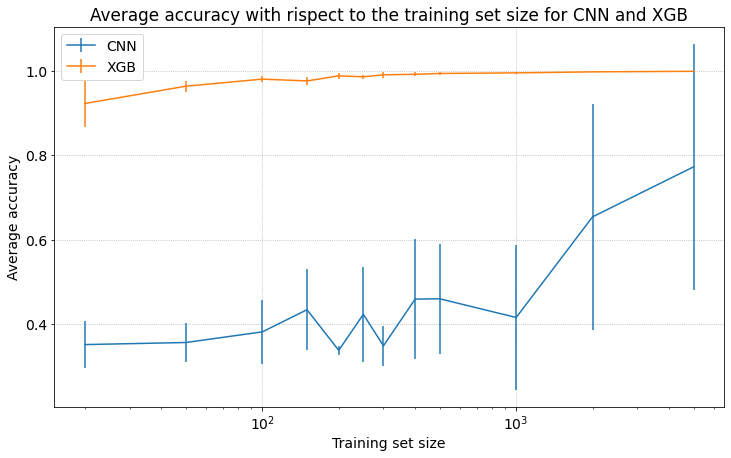

In [9]:
CNN_avg = np.mean(accuracy_scores_CNN,axis = 0)
CNN_std = np.std(accuracy_scores_CNN,axis = 0)

XGB_avg = np.mean(accuracy_scores_XGB,axis = 0)
XGB_std = np.std(accuracy_scores_XGB,axis = 0)

fig, ax = plt.subplots( figsize = ( 12, 7 ) )

ax.errorbar(Ns,y = CNN_avg, yerr= CNN_std , label = "CNN")
ax.errorbar(Ns,y = XGB_avg, yerr= XGB_std , label = "XGB")
plt.xscale("log")

ax.set_title( 'Average accuracy with rispect to the training set size for CNN and XGB' )
ax.set_xlabel( 'Training set size' )
ax.set_ylabel( 'Average accuracy' )
ax.grid( linestyle = 'dotted' )
ax.legend( loc = 'upper left' )


plt.show()

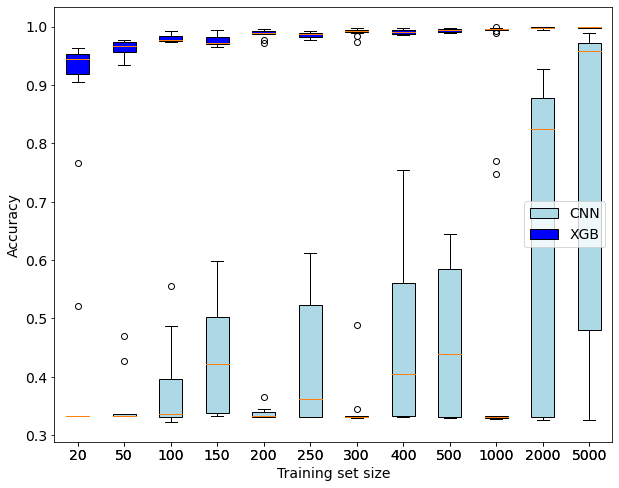

In [10]:
fig,axs = plt.subplots(1,1,figsize = (10,8))

box_CNN = axs.boxplot(accuracy_scores_CNN,
    labels = Ns,
    patch_artist= True,
    )
for patch in box_CNN['boxes']:
    patch.set_facecolor("lightblue")

box_XGB = axs.boxplot(accuracy_scores_XGB,
    labels = Ns,
    patch_artist= True,
    )
for patch in box_XGB['boxes']:
    patch.set_facecolor("blue")

axs.set_xlabel('Training set size')
axs.set_ylabel('Accuracy')
axs.legend([box_CNN["boxes"][0], box_XGB["boxes"][0]], ['CNN', 'XGB'], loc = 'best' )
plt.show()

## Task 1.b Most relevant features for XGBoost

------------- Feature importance sum = 1.0
------------- Showing feature with importance > 0.005
1 value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0 0.2822042
2 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.27336037
3 value__cid_ce__normalize_False 0.16535215
4 value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.1315366
5 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0 0.0453039
6 value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6 0.02976423
7 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2 0.008297996
8 value__last_location_of_maximum 0.007880213
9 value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0 0.0058954875


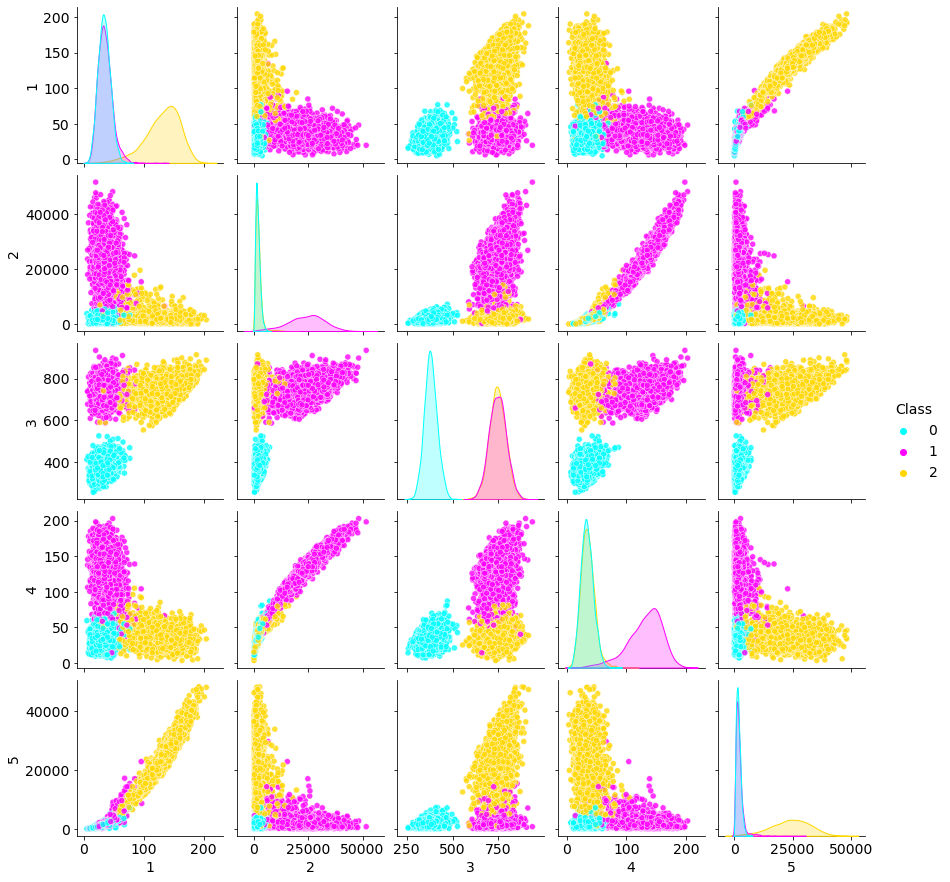

In [11]:
#get feature names
feature_names = x_features.columns.values

#empty dict
feat_imp = {}
#get f importance from model
for i,f in enumerate(feature_names):
    feat_imp[f] = XGB_model.feature_importances_[i]
#sort features depending on their importances
feat_imp = dict(sorted(feat_imp.items(), reverse=True, key=lambda item: item[1]))

minval=0.005
print('------------- Feature importance sum = '+str(np.sum(XGB_model.feature_importances_)))
print('------------- Showing feature with importance > '+str(minval))
for i,k in enumerate(feat_imp.keys()):
    if feat_imp[k]>minval: print(i+1,k,feat_imp[k])


# get feature names given importance order
features = list(feat_imp.keys())
#print(features)


# build dataframe for sns pairplot
df = pd.DataFrame({'1':x_features[features[0]],\
                   '2':x_features[features[1]],\
                   '3':x_features[features[2]],\
                   '4':x_features[features[3]],\
                   '5':x_features[features[4]],\
                   'Class':np.argmax(y,axis = 1)})
# pairplot with seaborn
pal = sns.blend_palette(["cyan","magenta","gold"],n_class)
sns.pairplot(df,hue='Class',plot_kws=dict(alpha=0.8),palette=pal);


Description of the features:

- 1 : This gives the variance of the data that is within the quantiles form 0.8 to 1.0 of the data values.
- 2 : This gives the mean of the data that is within the quantiles form 0.0 to 0.2 of the data values.
- 3 : Cid_ce - Estimate the complexity of the time series, it it the root of sum of square of nearest neighbourh change.
- 4 : This gives the mean of the data that is within the quantiles form 0.0 to 0.2 of the data values.
- 5 : This gives the mean of the data that is within the quantiles form 0.6 to 1.0 of the data values.
- 6 : This gives the variance of the data that is within the quantiles form 0.0 to 0.2 of the data values.

Possible explanation:

Looking through the list we se that the 6 first terms consist of inherently three different types of features. Features 1 and 6 is the variance in the data for the highest and lowest 20% of the data respectively. This intuitively makes sense as the pattern would either make the low or high variance be larger than if there is no pattern. Features 2,4 and 5 is the mean of the highest and lowest 20 %, and 40% highest for 5. This also seemes to make sense as the lowest and highest values would tend to be larger when pattern is present and then in either direction. The feature 3 is a good indication to distinguish if there is a pattern or not, but not what type as sign is lost since it is squared. The features is expected to be bigger when a pattern is present and smaller when not. 

One can from the figure see that the feature seperation is as more or less as explained. 

## Task 1.c Comparison FFNN vs XGBoost

OPTIONAL: with the features extracted by tsfresh, train a standard (non-convolutional) feed
forward neural network (FFNN) and compare the performances with those of XGBoost. Than
keep only the most relevant features from XGBoost and train another FFNN with this smaller
set (of features). Is the new FFNN working better than the one trained with all features?

In [44]:

def create_FFNNmodel(
    optimizer = "adam",
    hidden_layers = 4,
    number_of_nodes = 10,
    dropout = 0,
    activation = 'relu',
    weight_init = 'glorot_uniform',
    learning_rate = 0,
    L = x_features.values.shape[1]
    ):
    """
    returns a complied model with the given parameters
    
    Inputs
    ----------
    optimizer     :   optimizer passed when compiled default='adam'
    hidden_layers :   number of hidden layers in the model default = 4
    num_nodes     :   number of nodes in the hidden layers default = 10
    dropout       :   dropout rate for the hidden layers default = 0
    activation    :   activation function in the hidden layers default = 'relu'
    weight_init   :   weight initialization in the hidden layers default = 'glorot_uniform'
    learning_rate :   If set to a non-zero value this sets a Adam optimizer with this value
                      default 0

    """
    # Create sequential model
    model = Sequential()
    # Input layer
    model.add(Dense(L,input_shape=(L,),activation = 'relu'))
    # Loop over the hidden layers
    for i in range(hidden_layers):
        model.add(
            Dense(
            number_of_nodes,
            activation=activation,
            kernel_initializer=weight_init
            )
        )
        model.add(Dropout(dropout))
    
    # Output layer
    model.add(Dense(3, activation='softmax'))
    model.add(Flatten())
    
    # Check if learning rate should be modified
    if learning_rate != 0:
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    
    # Compile model
    model.compile(loss= 'binary_crossentropy',
    optimizer = optimizer,
    metrics = ['accuracy'])
    
    return model




def rescale_features(x_features : np.ndarray) -> "np.ndarray":
    """
    Normalize the features
    """
    x_features_rescale = np.copy(x_features)

    x_train_max = np.max(x_train, axis = 0)
    x_train_min = np.min(x_train, axis = 0)

    
    for i in range(x_train.shape[1]):
        # Check if the value has any variability
        if x_train_max[i] == x_train_min[i]:
            # Normalize if not constant zero
            if x_train_max[i] != 0:
                x_features_rescale[:,i] /= (x_train_max[i])
        
        else:
            x_features_rescale[:,i] =-1+ 2*(x_features_rescale[:,i] - x_train_min[i])/(x_train_max[i] - x_train_min[i])
            
    
    return x_features_rescale


x_features_rescale = rescale_features(x_features.values)

In [45]:
N_check = 10
# Added some more samples than whats in the task to see when they where compariable
Ns = [20, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 2000, 5000] 
N_validation = 5000 # Since we have a lot of samples

accuracy_scores_FFNN = np.zeros((N_check,len(Ns)))
accuracy_scores_XGB  = np.zeros((N_check,len(Ns)))

for n in tqdm(range(N_check)):
    for i,N in enumerate(Ns):
        FFNN_model = create_FFNNmodel()
    
        x_train,y_train,x_valid,y_valid = features_split(x_features_rescale,y,N_train=N, N_valid = N_validation )        
        
        # Prepare data for NN since normalization is needed
        y_train = tf.keras.utils.to_categorical(y_train, num_classes=n_class)
        
        FFNN_model.fit(x_train,y_train,verbose=0,epochs=EPOCHS,batch_size= BATCH_SIZE)

        y_pred_valid = FFNN_model.predict(x_valid)
        
        accuracy_scores_FFNN[n,i] = accuracy_score(y_valid, np.argmax(y_pred_valid,axis = 1))

        x_train,y_train,x_valid,y_valid = features_split(x_features.values,y,N_train=N, N_valid = N_validation )

        XGB_model = create_XGTBoostmodel(set_seed = False)
        x_train,y_train,x_valid,y_valid = features_split(x_features.values,y,N_train=N)
        XGB_model.fit(x_train,y_train,verbose=0)

        y_pred_val = XGB_model.predict(x_valid)
        accuracy_scores_XGB[n,i] = accuracy_score(y_valid,y_pred_val)


100%|██████████| 10/10 [07:40<00:00, 46.08s/it]


[0.1005226  0.10391645 0.02199767 0.02254845 0.03957512 0.01008317
 0.00618414 0.00770652 0.06186028 0.00137419 0.00085229 0.00076837]


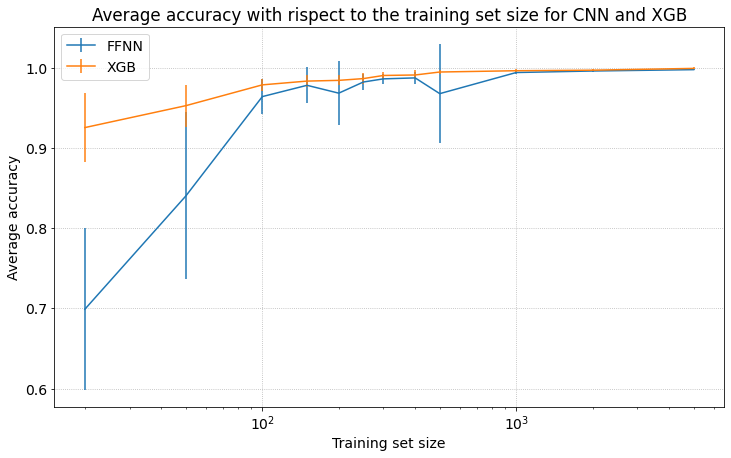

In [46]:
FFNN_avg = np.mean( accuracy_scores_FFNN,axis = 0 )
FFNN_std = np.std(  accuracy_scores_FFNN,axis = 0 )

XGB_avg  = np.mean( accuracy_scores_XGB,axis  = 0 )
XGB_std  = np.std(  accuracy_scores_XGB,axis  = 0 )

fig, ax  = plt.subplots( figsize = ( 12, 7 ) )

ax.errorbar(Ns,y = FFNN_avg, yerr = FFNN_std , label = "FFNN")
ax.errorbar(Ns,y = XGB_avg,  yerr = XGB_std ,  label = "XGB")
plt.xscale("log")

ax.set_title( 'Average accuracy with rispect to the training set size for FFNN and XGB' )
ax.set_xlabel( 'Training set size' )
ax.set_ylabel( 'Average accuracy' )
ax.grid( linestyle = 'dotted' )
ax.legend( loc = 'upper left' )

plt.show()

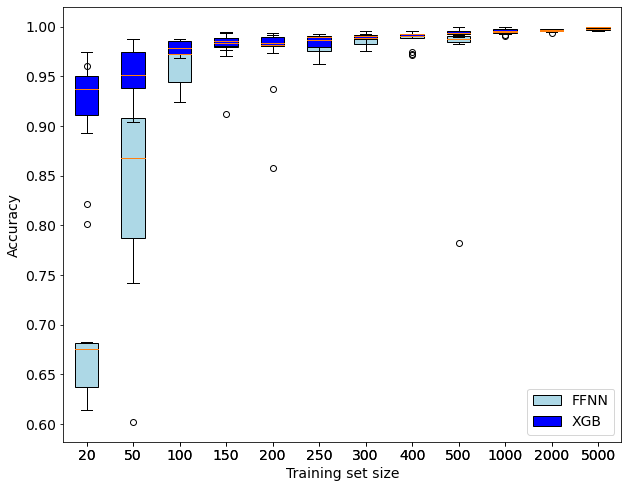

In [52]:

fig,axs = plt.subplots(1,1,figsize = (10,8))

box_FFNN = axs.boxplot(accuracy_scores_FFNN,
    labels = Ns,
    patch_artist= True,
    )
for patch in box_FFNN['boxes']:
    patch.set_facecolor("lightblue")

box_XGB = axs.boxplot(accuracy_scores_XGB,
    labels = Ns,
    patch_artist= True,
    )
for patch in box_XGB['boxes']:
    patch.set_facecolor("blue")

axs.set_xlabel('Training set size')
axs.set_ylabel('Accuracy')
axs.legend([box_FFNN["boxes"][0], box_XGB["boxes"][0]], ['FFNN', 'XGB'], loc = 'best' )
plt.show()

### Only Using the 10 most importatn parameters from XGB-Boost for FFNN

In [57]:
#get feature names
feature_names = x_features.columns.values
N_best_features = 10

#empty dict
feat_imp = {}
#get f importance from model
for i in range(feature_names.size):
    feat_imp[i] = XGB_model.feature_importances_[i]

#sort features depending on their importances
feat_imp = dict(sorted(feat_imp.items(), reverse=True, key=lambda item: item[1]))

x_features_important = np.zeros((x_features.shape[0],N_best_features))

for i,k in enumerate(feat_imp.keys()):
    if i == N_best_features:
        break
    x_features_important[:,i] = x_features_rescale[:,k]


In [59]:
N_check = 10
# Added some more samples than whats in the task to see when they where compariable
Ns = [20, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 2000, 5000] 
N_validation = 5000 # Since we have a lot of samples

accuracy_scores_FFNN_important = np.zeros((N_check,len(Ns)))


for n in tqdm(range(N_check)):
    for i,N in enumerate(Ns):
        FFNN_model = create_FFNNmodel(L = N_best_features)
    
        x_train,y_train,x_valid,y_valid = features_split(x_features_important,y,N_train=N, N_valid = N_validation )        
        
        # Prepare data for NN since normalization is needed
        y_train = tf.keras.utils.to_categorical(y_train, num_classes=n_class)
        
        FFNN_model.fit(x_train,y_train,verbose=0,epochs=EPOCHS,batch_size= BATCH_SIZE)

        y_pred_valid = FFNN_model.predict(x_valid)
        
        accuracy_scores_FFNN_important[n,i] = accuracy_score(y_valid, np.argmax(y_pred_valid,axis = 1))


100%|██████████| 10/10 [04:08<00:00, 24.84s/it]


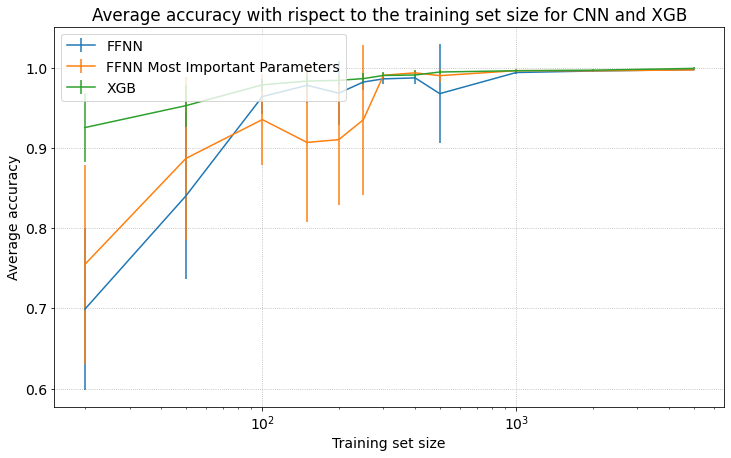

In [61]:
FFNN_important_avg = np.mean( accuracy_scores_FFNN_important,axis = 0 )
FFNN_important_std = np.std(  accuracy_scores_FFNN_important,axis = 0 )

XGB_avg  = np.mean( accuracy_scores_XGB,axis  = 0 )
XGB_std  = np.std(  accuracy_scores_XGB,axis  = 0 )


fig, ax  = plt.subplots( figsize = ( 12, 7 ) )

ax.errorbar(Ns,y = FFNN_avg, yerr = FFNN_std , label = "FFNN")
ax.errorbar(Ns,y = FFNN_important_avg, yerr = FFNN_important_std , label = "FFNN Most Important Parameters")
ax.errorbar(Ns,y = XGB_avg,  yerr = XGB_std ,  label = "XGB")
plt.xscale("log")

ax.set_title( 'Average accuracy with rispect to the training set size for CNN and XGB' )
ax.set_xlabel( 'Training set size' )
ax.set_ylabel( 'Average accuracy' )
ax.grid( linestyle = 'dotted' )
ax.legend( loc = 'upper left' )

plt.show()

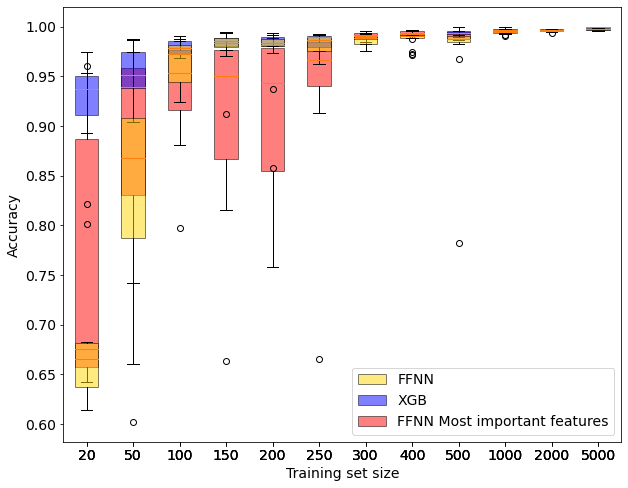

In [69]:
fig,axs = plt.subplots(1,1,figsize = (10,8))



box_FFNN_important = axs.boxplot(accuracy_scores_FFNN_important,
    labels = Ns,
    patch_artist= True,
    )
for patch in box_FFNN_important['boxes']:
    patch.set_facecolor("red")
    patch.set_alpha(0.5)

box_XGB = axs.boxplot(accuracy_scores_XGB,
    labels = Ns,
    patch_artist= True,
    )
for patch in box_XGB['boxes']:
    patch.set_facecolor("blue")
    patch.set_alpha(0.5)

box_FFNN = axs.boxplot(accuracy_scores_FFNN,
    labels = Ns,
    patch_artist= True,
    )
for patch in box_FFNN['boxes']:
    patch.set_facecolor("gold")
    patch.set_alpha(0.5)



axs.set_xlabel('Training set size')
axs.set_ylabel('Accuracy')
axs.legend([box_FFNN["boxes"][0], box_XGB["boxes"][0],box_FFNN_important['boxes'][0]], ['FFNN', 'XGB',"FFNN Most important features"], loc = 'best' )
plt.show()

# Task 2, 2D Classification of non-linear function

Goal: find the simplest yet effective XGBoost model that keeps a good accuracy. 

## Grid Search

In [164]:
n_estimatorss = range(1,30,2)
learning_rates = [0.2, 0.3, 0.4]
gammas = [0, 0.1 , 1]
max_depths = [1,2,4,6, 8, 10, 12]
reg_lambdas = [0.1,1,10]


min_child_weights = [0, 1, 10]
max_delta_steps = [0, 1, 10]
subsampless = [0,0.5]

accuracies = []
x_train,y_train, x_valid, y_valid = create_datasets(N_train=1000,N_valid= 4000, TYPE= 4)

i = 0
kw_dicts = {}
for n_estimators in n_estimatorss:
    for gamma in gammas:
        for max_depth in max_depths:
            for reg_lambda in reg_lambdas:
                for learning_rate in learning_rates:
                    for min_child_weight in min_child_weights:
                        for max_delta_step in max_delta_steps:
            
                            kw_dicts[i] = {
                                "n_estimators" : n_estimators,
                                "gamma" : gamma,
                                "max_depth" : max_depth,
                                "reg_lambda" : reg_lambda,
                                "learning_rate" : learning_rate,
                                "min_child_weight" : min_child_weight,
                                "max_delta_step" : max_delta_step
                            }
                            i += 1


for kw_dict in tqdm(kw_dicts.values()):
    XGB_model = create_XGTBoostmodel(
        **kw_dict
        )
    XGB_model.fit(x_train,y_train)
    y_valid_predict = XGB_model.predict(x_valid)
    accuracy = accuracy_score(y_valid,y_valid_predict)
    accuracies.append(accuracy)

accuracies = np.array(accuracies)

100%|██████████| 25515/25515 [14:23<00:00, 29.55it/s]


In [229]:
best_index = accuracies.argmax()
print("The best parameters are:")
best_acc = accuracies[best_index]
print(f"{kw_dicts[best_index]} : acc = {accuracies[best_index]}")

The best parameters are:
{'n_estimators': 29, 'gamma': 0, 'max_depth': 12, 'reg_lambda': 1, 'learning_rate': 0.3, 'min_child_weight': 1, 'max_delta_step': 0} : acc = 0.9615


In [215]:
df = pd.DataFrame(kw_dicts)
df = df.transpose()
df["accuracy"] = accuracies

df = df.sort_values("accuracy",ascending=False)

df_n_best = df[0:10]


def groupby_plot(group,*, x = "n_estimators", y = "accuracy",kind = "line"):
    fig, ax = plt.subplots()
    for label, grp in df.groupby(group):
        grp.plot(x = x, y = y ,ax = ax, label = f"{group}:{label}", kind = kind)
    plt.tight_layout()
    plt.show()

df_n_best

,n_estimators,gamma,max_depth,reg_lambda,learning_rate,min_child_weight,max_delta_step,accuracy
24339,29.0,0.0,12.0,1.0,0.3,1.0,0.0,0.96150
24341,29.0,0.0,12.0,1.0,0.3,1.0,10.0,0.96150
20937,25.0,0.0,12.0,1.0,0.3,1.0,0.0,0.96100
23125,27.0,0.1,10.0,1.0,0.3,1.0,1.0,0.96100
24826,29.0,0.1,10.0,1.0,0.3,1.0,1.0,0.96100
24312,29.0,0.0,12.0,0.1,0.3,1.0,0.0,0.96100
24314,29.0,0.0,12.0,0.1,0.3,1.0,10.0,0.96100
20939,25.0,0.0,12.0,1.0,0.3,1.0,10.0,0.96100
19211,23.0,0.0,12.0,0.1,0.3,1.0,10.0,0.96075
19209,23.0,0.0,12.0,0.1,0.3,1.0,0.0,0.96075


The Gridsearch shows that the best XGB-models that score the best are those with the highest number of trees and max_depth among the values tested. This indicates that the models in general performs better with an increased complexity. However, good results can be obtained with a lower amount of decision trees and smaller depth. The top ten models seem to indicate that the depth and number of estimators are the most important factors as the top ten models score approximately the same, even though the values of some of the other parameters differ.

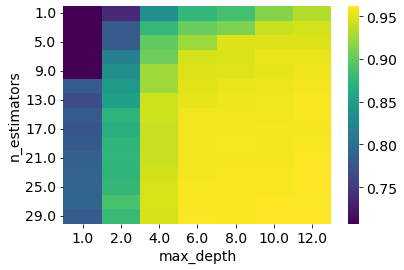

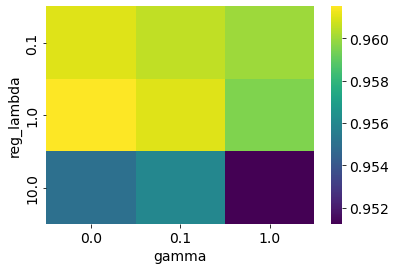

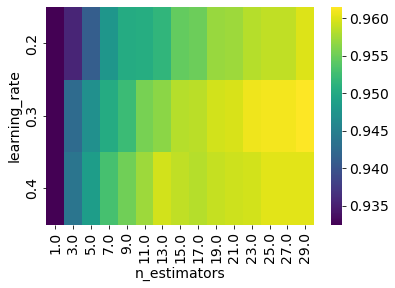

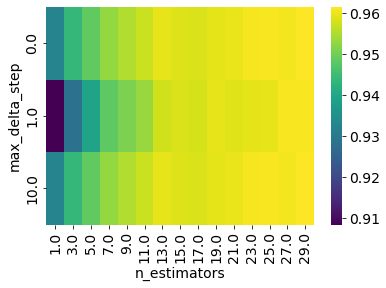

In [237]:
def max_pool_heatmap(x_column, y_column):
    df1 = df.pivot_table("accuracy",y_column,x_column,aggfunc=np.max)
    sns.heatmap(df1,cmap = "viridis")
    plt.show()

max_pool_heatmap("max_depth","n_estimators")
max_pool_heatmap("gamma","reg_lambda")
max_pool_heatmap("n_estimators","learning_rate")
max_pool_heatmap("n_estimators","max_delta_step")

The heatplots shows the improvement in accuracy as a function of the different parameters. In general, with an increasing depth one can see that good accuracies can also be obtained with a lower number of estimators. Below a depth of 6 however, the accuracy drops substantially, and an increased number of estimators is not able to wigh up for that. This implies that the depth of the model is perhaps the most important factor, while the number of estimators can increase the accuracy further. This does hoewever yield a more complex model. One can see that a model with a depth of 6 and number of estimators equal to 7 yields good results, and could therefore be a good compromize between the two parameters. This is investigated further down.

The heatplot for lambda and gamma shows that the optimal values for lambda and gamma are 1 and zero respectively. This is also visible in the list of the top ten models, as these are the values they use.

The best learning rate for the classification of the time series seem to be 0.3, and the accuracy increases further with the number of estimators as expected. The parameter max delta step however seem to have little impact on the result. In the overview of the best models, the models with all other parameters equal perform the same regardless of the value of max delta step. One can also see this from the heatmap as all the values tested generate about the same accuracy with the same number of estimators.

In [239]:
df1 = df[df["max_depth"] == 6]
df1[df1["n_estimators"] == 7].sort_values("accuracy",ascending=False)[0:10]

,n_estimators,gamma,max_depth,reg_lambda,learning_rate,min_child_weight,max_delta_step,accuracy
5933,7.0,0.1,6.0,0.1,0.4,0.0,10.0,0.94550
5931,7.0,0.1,6.0,0.1,0.4,0.0,0.0,0.94550
5366,7.0,0.0,6.0,0.1,0.4,0.0,10.0,0.94275
5364,7.0,0.0,6.0,0.1,0.4,0.0,0.0,0.94275
6500,7.0,1.0,6.0,0.1,0.4,0.0,10.0,0.94100
6498,7.0,1.0,6.0,0.1,0.4,0.0,0.0,0.94100
6494,7.0,1.0,6.0,0.1,0.3,1.0,10.0,0.93950
6492,7.0,1.0,6.0,0.1,0.3,1.0,0.0,0.93950
6503,7.0,1.0,6.0,0.1,0.4,1.0,10.0,0.93850
6501,7.0,1.0,6.0,0.1,0.4,1.0,0.0,0.93850


For comparison with the best models of the grid search, the ten best estimators with a depth of 7 and number of estimators equal to 6 are shown, as this less complex combination was seen to yield good results in the investigation of estimators and depth. Except from the fact that the learning rate is increased to 0.4 in this case, the rest of the parameters show the same trend as indicated by the different heatmaps. Even though these models are significantly les complexs than the best performing models, their accuracies are still good, and not far from the performancees of the best models. Hence, this implies that this model is suffient for the task, and that the depth, number of estimators, and learning rate are the most important parameters of the model.

## Animation of classification
Since the gif takes a substantial space to store one need to run the localy to view, aka uncomment the two last cells and run. Then the prelimenary cells before task 1 start needs to be run together with the one underneight

In [240]:
opt_n_estimators = 7
opt_gamma = 0.1
opt_max_depth = 6
opt_reg_lambda = 0.1
opt_learning_rate = 0.4
opt_min_child_weight = 0.0
opt_max_delta_step = 10

x_train,y_train, x_valid, y_valid = create_datasets(N_train=1000,N_valid= 4000, TYPE= 4)

def animate(frame,label_func,**kwargs):
    XGB_model = create_XGTBoostmodel(
        **kwargs
        )

    XGB_model.fit(x_train,y_train)

    y_valid_predict = XGB_model.predict(x_valid)

    scatter.set_array(y_valid_predict)
    accuracy = accuracy_score(y_valid,y_valid_predict)
    ax.set_xlabel(label_func(frame,accuracy))

def depth_label(frame,accuracy):
    return f"max_depth : {frame+1} Accuracy : {round(accuracy,4)}"

def estimators_label(frame,accuracy):
    return f"n_estimators : {frame+1} Accuracy : {round(accuracy,4)}"

In [243]:
"""
fig,ax = plt.subplots()
plt.xlim(-2,2)
plt.ylim(-2,2)
ax.set_xlabel(f"Max_depth : {0} Accuracy : 0.5000 ")
scatter = ax.scatter(x_valid[:,0],x_valid[:,1],c = y_valid)

anim = FuncAnimation(fig, 
    lambda frame: animate(frame,
        depth_label,
        max_depth = frame+1,
        n_estimators = opt_n_estimators,
        gamma = opt_gamma,
        learning_rate = opt_learning_rate,
        max_delta_step = opt_max_delta_step,
        reg_lambda = opt_reg_lambda,
        min_child_weight = opt_min_child_weight,
        ),
    frames = 19,
    interval = 500)

plt.close()
display.HTML(anim.to_jshtml())
"""

'\nfig,ax = plt.subplots()\nplt.xlim(-2,2)\nplt.ylim(-2,2)\nax.set_xlabel(f"Max_depth : {0} Accuracy : 0.5000 ")\nscatter = ax.scatter(x_valid[:,0],x_valid[:,1],c = y_valid)\n\nanim = FuncAnimation(fig, \n    lambda frame: animate(frame,\n        depth_label,\n        max_depth = frame+1,\n        n_estimators = opt_n_estimators,\n        gamma = opt_gamma,\n        learning_rate = opt_learning_rate,\n        max_delta_step = opt_max_delta_step,\n        reg_lambda = opt_reg_lambda,\n        min_child_weight = opt_min_child_weight,\n        ),\n    frames = 19,\n    interval = 500)\n\nplt.close()\ndisplay.HTML(anim.to_jshtml())\n'

In [244]:
"""
fig,ax = plt.subplots()
plt.xlim(-2,2)
plt.ylim(-2,2)
ax.set_xlabel(f"Max_depth : {0} Accuracy : 0.5000 ")
scatter = ax.scatter(x_valid[:,0],x_valid[:,1],c = y_valid)

anim = FuncAnimation(fig, 
    lambda frame: animate(frame,
        estimators_label,
        max_depth = opt_max_depth,
        n_estimators = frame +1,
        gamma = opt_gamma,
        learning_rate = opt_learning_rate,
        max_delta_step = opt_max_delta_step,
        reg_lambda = opt_reg_lambda,
        min_child_weight = opt_min_child_weight,
        ),
    frames = 30,
    interval = 500)

plt.close()
display.HTML(anim.to_jshtml())
"""


'\nfig,ax = plt.subplots()\nplt.xlim(-2,2)\nplt.ylim(-2,2)\nax.set_xlabel(f"Max_depth : {0} Accuracy : 0.5000 ")\nscatter = ax.scatter(x_valid[:,0],x_valid[:,1],c = y_valid)\n\nanim = FuncAnimation(fig, \n    lambda frame: animate(frame,\n        estimators_label,\n        max_depth = opt_max_depth,\n        n_estimators = frame +1,\n        gamma = opt_gamma,\n        learning_rate = opt_learning_rate,\n        max_delta_step = opt_max_delta_step,\n        reg_lambda = opt_reg_lambda,\n        min_child_weight = opt_min_child_weight,\n        ),\n    frames = 30,\n    interval = 500)\n\nplt.close()\ndisplay.HTML(anim.to_jshtml())\n'